# Lesson 3 - Recurrent Neural Networks

This lesson introduces the important class of Recurrent Neural Networks, or RNNs.
The student will understand how compact mutual connections in a layer can store information about the past and integrate information about the present, and will learn how to extend the backpropagation algorithm to handle time-dependent tasks.
This knowledge will be applied for regressing Arterial Blood Pressure from two other physiological signals.

### Summary

* [Finding patterns in time](#timepatterns)
* [BackPropagation Through Time](#bptt)
* [*Stateful* vs *stateless*](#statefulstateless)
* [Predicting Arterial Blood Pressure](#bloodpressure)
* [The exploding/vanishing gradient problem](#explodevanish)


<a id=timepatterns></a>
### Finding patterns in time

Feedforward models, as the one built during the previous lesson, struggle to capture time-dependent relationships hidden in sequential data.
This happens because, after each forward and backward pass, all the internal information and extracted features are flushed and replaced by the next sample's, and as a consequence all the memory about what was in the input is lost.

Suppose $X$ is a set of sequences $x = (x_1, x_2, \dots x_T), T \in \mathbb{N}$.
There are two ways to extract information from such sequences: looking at a complete sequence as a whole, or trying to get an understanding of it piece after piece, as they are revealed.

The first approach corresponds to a simultaneous analysis of the sequence points.
This solution requires connections for each of the timesteps $x_t$, a concern that brings along two issues:
* since $T \in \mathbb{N}$ could be arbitrarily large, a feedforward ANN to process long sequences could require too much memory to hold all the $T$ weights for just the first layer;
* from a more theoretical standpoint, posing design constraints on $T$ could be unreasonable: for example, natural language sentences don't have rigid constraints on the number of words they contain!

The first results on the capability of fixed-size ANNs to hold memories, in the basic sense of being capable of storing in a robust way some information about past states, were obtained by John Hopfield in a famous [paper](https://bi.snu.ac.kr/Courses/g-ai09-2/hopfield82.pdf).
At the time, the backpropagation algorithm had not been invented yet, and Hopfield's model was a proof of concept on single layer models with **mutual connections**, where each neuron could stimulate the others and even itself: remember that the perceptron and also feedforward models avoid any connection between neurons of the same layer.

The concept of **self-connections** was extremized in Hopfield's model in the sense that the neurons were unable to gather information from the external world: this limitation is a clear obstacle towards the usage of such ANNs for real world regression tasks.
But this idea was soon translated into the concept of **internal state** or **internal memory** of a network.
In 1986, a few months after backpropagation appeared, [Jordan](http://cseweb.ucsd.edu/~gary/PAPER-SUGGESTIONS/Jordan-TR-8604.pdf) proposed a two-layer model introducing the concept of an internal state, which was later developd also by [Elman](https://crl.ucsd.edu/~elman/Papers/fsit.pdf).
The basic idea of this kind of networks is that a layer's output

$$s_{t} = \sigma(x_{t} W^{(X)} + s_{t-1} W^{(S)})$$

can be *duplicated*, a copy being passed on to the next transformation while the second copy is *set aside* and reused as *information about the past* at next time step, when it will be combined with the *information about the present* coded by the input $x_{t+1}$.

What is not yet clear is how error signals could adjust the weights to improve the generation of the *memory states* $s_{1}, s_{2}, \dots s_{T}$.


<a id=bptt></a>
### BackPropagation Through Time

The problem of with backpropagation in Recurrent Models is how to interpret the time dimension.

Analyzing the previous formula, we saw that one of the two copies of the internal memory $s_{t}$ is picked when it exits the computational node, and fed back to the same node at the next time step as input.

Our mental limit is that we give a computational node an immutable identity, and don't think that *the computational node will be a different one when it will process different inputs*: its functioning will be the same, but its state, and thus its global identity, will not.

We can thus see each computational node as uniquely determined only at a fixed timestep $t$, with its computed state $s_{t}$ exiting the node (red arrow in the figure below) at time $t$ and entering another node (blue arrow in the figure below) at time $t+1$.

<img src='figures/rnn_unfolded.png', width=640, height=640></img>

From the figure it emerges that a RNN can be thought at as a sequence of feedforward models (*snapshots* of the RNN model at different timesteps, or **virtual copies**) that passes their internal state as *batons* in a relay race.

This picture brings RNNs in the framework of standard backpropagation, but with an enormously larger amount of connections.
To understand how BackPropagation Through Time (BPTT for short) works, we will considerate how an error signal $\delta y_{t+3}$ might flow back to the hidden state of the first layer at time $t+1$, i.e. $h_{t+1}^{1}$.

<img src='figures/rnn_errorpaths.png', width=480, height=480></img>

Reverting the notation introduced in the previous lesson, where the symbol $s$ stood for *score* and the symbol $h$ stood for *hidden state*, the activation $h = \sigma(s)$, when talking of RNNs we will use the symbol $h_{t}^{l}$ to indicate the *scores* of hidden layer $l$ at timestep $t$, and $s_{t}^{l} = \sigma(h_{t}^{l})$ to denote its activation.

We see from the figure that the error between $y_{t+3}$ and $h_{t+1}^{1}$ can flow through three distinct paths:
* the *higher* path (red), due to the error that was induced by $h_{t+1}^{1}$ on the next feature extracted at the same timestep, $h_{t+1}^{2} \in H^2$, and then propagated through time to other features in the same feature space $H^2$, from $h_{t+1}^{2}$ to $h_{t+2}^{2}$, from $h_{t+2}^{2}$ to $h_{t+3}^{2}$, and finally from $h_{t+3}^{2}$ to $y_{t+3}$;
* the *middle* path (orange), due to the error induced by $h_{t+1}^{1} \in H^1$ on the next latent representation $h_{t+2}^{1}$ in the same space $H^1$, which induced an error on a higher level feature $h_{t+2}^{2} \in H^2$, and from this passed on through time to $h_{t+3}^{2}$ and finally to $y_{t+3}$;
* the *lower* path (violet), due to the error induced through time by $h_{t+1}^{1}$ to $h_{t+2}^{1}$ first and to $h_{t+1}^{3}$ then, and that from this propagated to the higher level features $h_{t+3}^{2}$ and $y_{t+3}$.

Now, how can we translate these observations into a consistent computational procedure for BPTT?

We have two options.
The first one is a **time unstack** of error signals.

<img src='figures/rnn_timeunstack.png', width=480, height=480></img>

In this configuration, we reuse the similarity of a *relay race* which was used to explain forward propagation and imagine to run the race it in reverse mode.
We thing to each timestep *copy* of the network as an independent feedforward model, which we denote with $f_{t}(x_{t}, s_{t-1}, \theta)$.
This model takes as inputs the error signals $\delta y_{t}$ and $\delta s_{t}$, and consumes them to produce error signals $\delta \theta_{t}$ and $\delta s_{t-1}$.
This last error signal, $\delta s_{t-1}$, is passed back as a baton to the previous memeber of the relay, $f_{t-1}(x_{t-1}, s_{t-2}, \theta)$, and the process is repeated.

For example, a run of the BPTT algorithm on the previous graph would first call $f_{t+3}(x_{t+3}, s_{t+2}, \theta)$, pass $\delta y_{t+3}$ and $\delta s_{t+3}$ to it (the blue arrows on the right side of the picture) and produce $\delta \theta_{t+3}$ and $\delta s_{t+2}$.
This last signal will then be consumed by $f_{t+2}(x_{t+2}, s_{t+1}, \theta)$ together with $\delta y_{t+2}$ (the green arrows in the picture) and will produce $\delta \theta_{t+2}$.
And so on until the timestep $t = 1$ is reached in the *virtual network copy* $f_{1}(x_{1}, s_{0}, \theta)$.
The state $s_{0}$ represents the *virgin memory* of the model before processing any information, and is called **initial state**.
Notice that the parameters $\theta$ are shared by all these *virtual copies*, and thus the updates $\delta \theta_{t}, t=1,2,\dots T$ should be summed up to yield a global parameters update when the error signals reach the first virtual copy.

This interpretation of BPTT allows a straightforward implementation.
Notice that virtual copies of the model $f_{t}(x_{t}, s_{t-1}, \theta)$ differ only for the input operands $x_{t}$ and $s_{t-1}$, while the parameters $\theta$ remain unchanged operands.
If we add to `Node` classes an `history` list attribute and methods `pop_state` and `push_state`, we can thus store and retrieve virtual copies just pushing and popping operands from `Node`s' histories.
Parameter should be ignored during this stack operations, since they remain unchanged from copy to copy.

This implemention comes with an important drawback, though: as shown in the *time-vs-threads* graph above, BPTT invokes `backward` methods of each operation sequentially, and no *inter-node* parallelism is exploited (just *intra-node* parallelism, the one that can be used for example when backpropagatin errors through a linear transformation: $\delta x = \delta h W^T$).

From a parallelization perspective, the **depth unstack** of error signals is more appealing.

<img src='figures/rnn_depthunstack.png', width=480, height=480></img>

As we can see, computing the incoming error signals $\delta h_{t}^{2}$ (navy blue) and $\delta h_{t+1}^{1}$ (dark orange) can be done concurrently, since they both require to compute a single error signal vector $\delta h_{t+1}^{2}$ (dark cyan): as soon as this last signal is available, the former two can be computed comcurrently (provided the hardware architecture allows to do so).

This implementation is the one actually used in frameworks as Theano or TensorFlow, but is more complex and we will thus implement the first one, the time unstack.


<a id=statefulstateless></a>
### *Stateful* vs *stateless*

In computer science, *stateful* and *stateless* are properties of functions.
And since RNNs are a particular type of ANNs, which are in ultimate anlysis approximators of functions, the definition that we will now give can be extended to the models represented by RNNs.

A **stateless** function $f: X \to Y$ is a deterministic function.
Which is, when the input $x \in X$ is fixed, its transformed counterpart $y = f(x)$ will be fixed.
The behaviour of the function is thus stable and predictable.

A **stateful** function $g: X \to Y$ is instead a stochastic process.
Which is, even when presented the same input $x$, the map $g$ can produce different results, for example $y_1 = g(x)$ and $y_2 = g(x)$.
Mathematically, this can happen when $g$ is not a *perfect model* of the relation between $X$ and $Y$.
For example, $g$ could depend on a hidden random variable $s$, making it a map $g: X \times S \to Y$.
This is exactly the case for RNNs.

So, which is the advantage of stateful models versus stateless models?

Stateless models are really useful when the *stability* of the result is crucial.
Suppose you are building a model from the space $X$ of English books to the space $Y$ of German books, i.e. a language translation model.
Clearly, the way a book $x \in X$ is translated should not depend on other information other than $x$ itself.
Thus, to prevent *rubbish context* to influence the translation, the mapping $f$ should be able to focus only on the sequence of words that compose the text, and the initial state $s_{0}$ of the modelling RNN should be thus reset to a *zero state* whenever a new book is passed to it for translation.
Thus, stateless models can *discard unuseful context* by resetting their internal state whenever a brand new sequence is passed in.
But this is only feasible when the kind of sequence (that we remember is a data point $x \in X$) can be clearly and naturally separated from the others.

Stateful models are instead useful when there is some unknown *external noise* that influences the behaviour of the mapping $g: X \to Y$.
Suppose you are building a financial prediction model to link the cost of a good, quantified by $x \in X$, to the cost of another good $y \in Y$.
The dependence of $y$ from $x$ is not always neat; almost always, it will probably be just correlated, but not fully dependent.
As an example, if today wheat costs $x_{t}$ and bread costs $y_{t}$, it is likely that if tomorrow the wheat will cost $x_{t+1} > x_{t}$ then also the bread will $y_{t+1} > y_{t}$.
But maybe bakers have been really provident, saving some wheat today expecting tomorroy there will not be so much as today, and before increasing the bread's cost they can keep it the same for a few days: as a consequence, even if $x_{t+1} > x_{t}$, we will have $y_{t+1} = y_{t}$.
A stateless model is uncapable of retaining this kind of *context* information, since at certain moments it's reset.

To this end, we need `Node`s to keep an `initial_state` that should be reset (if they are part of stateless models) or simply saved (if they are part of stateful models).
In fact, after the last virtual copy of the network has processed its inputs $s_{T-1}$ and $x_{T}$ and produced $s_{T}$, we cannot push them into `history` lists, since BPTT will pop and then discard them.
This information thus requires an appropriate attribute field to be stored.


In [1]:
import numpy as np


class Node(object):
    """Create an operation.

    Each operation takes an input consisting of one ore more operands (which
    are themselves states of other operations) and computes an output state.
    For BackPropagation, the operation should i) accumulate incoming errors,
    ii) then compute how to distribute the corresponding outgoing errors to
    input nodes; if a node contains trainable parameters, it should notify the
    framework that its state can be modified.
    Recurrent cells also require to store an initial internal memory state.
    For BackPropagation Through Time (BPTT), every operation should keep a
    history record of its state, a stack where to push states after each
    timestep of forward propagation and from which to pop them during BPTT.

    Attributes:
        inbound_nodes (:obj:`list` of :obj:`Node`): the operations whose
            states are required to perform the implemented operation.
        outbound_nodes (:obj:`list` of :obj:`Node`): the operations which
            require this operation's state for their computations.
        state (:obj:`ndarray`): the output of the operation.
        incoming_error (:obj:`ndarray`): the error signal collected from
            outbound nodes.
        outgoing_errors (:obj:`dict` of :obj:`ndarray`): the error signals
            to be communicated to inbound nodes.
        is_trainable (:obj:`Bool`): whether the node contains trainable
            parameters.
        initial_state (:obj:`None` or :obj:`ndarray`): the internal memory of
            the operation.
        history (:obj:`list` of :obj:`ndarray`): stack of subsequent states
            of the node.

    Methods:
        push_state: push the current state on self.history stack.
        pop_state: pop last state from self.history stack.
        forward: compute the output of the operation.
        backward: compute the outgoing error signals.

    """

    def __init__(self, inbound_nodes=list()):
        """Create a differentiable operation.

        Args:
            inbound_nodes (:obj:`list` of :obj:`Node`): the operations
                whose states are required to perform the implemented operation.

        """
        self.inbound_nodes = inbound_nodes
        # communicate to inbound nodes that a node has been added on top of them
        for node in self.inbound_nodes:
            node.outbound_nodes.append(self)
        self.outbound_nodes = list()
        self.state = None
        self.incoming_error = None
        self.outgoing_errors = dict()
        self.is_trainable = False
        self.initial_state = None
        self.history = list()

    def push_state(self):
        self.history.append(self.state)

    def pop_state(self):
        self.state = self.history.pop()

    def forward(self):
        raise NotImplementedError

    def backward(self):
        raise NotImplementedError


In [2]:
class RNNCell(Node):
    def __init__(self, x, w_xs, w_ss, initial_state):
        Node.__init__(self, inbound_nodes=[x, w_xs, w_ss])
        self.initial_state = initial_state
        self.inbound_nodes.append(self)
        self.outbound_nodes.append(self)
        self.outgoing_errors[self] = np.zeros_like(initial_state)

    def forward(self):
        x = self.inbound_nodes[0].state
        w_xs = self.inbound_nodes[1].state
        w_ss = self.inbound_nodes[2].state
        logits = np.dot(x, w_xs) + np.dot(self.state, w_ss)
        self.state = np.tanh(logits)

    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]
        # propagate error through tanh
        error_tanh = (1+self.state) * (1-self.state) * self.incoming_error
        # propagate error through addition
        error_xwxs = error_tanh
        error_swss = error_tanh
        # propagate error to x and w_xs
        x = self.inbound_nodes[0].state
        w_xs = self.inbound_nodes[1].state
        self.outgoing_errors[self.inbound_nodes[0]] = np.dot(error_xwxs, w_xs.T)
        self.outgoing_errors[self.inbound_nodes[1]] = x[None, :].T * error_xwxs[i]
        # propagate error to self and w_ss
        wss = self.inbound_nodes[2].state
        self.outgoing_errors[self.inbound_nodes[2]] = self.state[None, :].T * error_swss[i]
        self.outgoing_errors[self] = np.dot(error_swss, wss.T)


<a id=bloodpressure></a>
### Predicting Arterial Blood Pressure

[MIMIC II databases](https://physionet.org/mimic2/) are collections of physiological data for biomedical research, which are in part publicly available.

Many physiological data can be naturally represented as sequential signals.
Some vital signals are easy to monitor; but other, important signals cannot be measured equally easily.
One example is Arterial Blood Pressure (ABP): its direct measurement requires cannulas to be inserted directly into a patient's veins, which is neither cheap nor desirable.
Other signals, such as electrocardiography (ECG) or photopletismography (PPG) require less invasive measurement techniques.
If we could tell $ABP(t)$ depending only on $ECG(t)$ and $PPG(t)$, i.e. if we could retrieve a model

$$a(t) = f(e(t), p(t))$$

it would surely be a great deal.


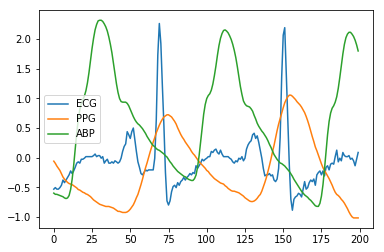

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale

# load data
file = './src/tests/data/blood_pressure.txt'
dataset = pd.read_csv(file, sep=';')
X = dataset.values[:, (3, 1)]
Y_hat = dataset.values[:, 2][:, None]

# normalize data
X = scale(X, axis=0)
Y_hat = scale(Y_hat, axis=0)

# plot data
timewindow = range(500, 700)
fig1 = plt.figure()
ax = fig1.gca()
ax.plot(X[timewindow, 0], label='ECG')
ax.plot(X[timewindow, 1], label='PPG')
ax.plot(Y_hat[timewindow], label='ABP')
ax.legend()
plt.show()


From the figure, there seems to be a high correlation between the ABP (green signal) and ECG/PPG (blue/green respectively).

Our next step, is to define the training samples for the model.
A natural choice could be setting a parameter `time_steps` that define a splitting length for the sequential signals 

$$x(t) = \begin{pmatrix} x_1(t) \\ x_2(t) \end{pmatrix}$$

and $y(t)$, where $x_1$ represents ECG, $x_2$ represents PPG and $y$ stands for the ABP signal.


In [4]:
time_steps = 10

# remove samples in order to have a multiple of `time_steps` of them
X = X[len(X)%time_steps:, :]
Y_hat = Y_hat[len(Y_hat)%time_steps:, :]

# reshape measurements to make sequential samples
X = X.reshape((X.shape[0]//time_steps, time_steps, X.shape[1]))
Y_hat = Y_hat.reshape((Y_hat.shape[0]//time_steps, time_steps, Y_hat.shape[1]))

# make batches
samples = list(zip(X, Y_hat))
val = 0.10
num_val_samples = int(val * len(samples))
train_samples = samples[:num_val_samples]
valid_samples = samples[num_val_samples:]


The global sequence is splitted in subsequences of length `time_steps = 10`, which are then grouped in two sets: a training set and a validation set, this last one containing abount 10% of the total amount of subsequences.

Now that the data is prepared, we should build up and train the model.


In [5]:
import sys
sys.path.insert(0, './src')

from network_management import *
from nodes import Placeholder, Variable, Linear, RNNCell, MSE
from trainers import SGD


In [6]:
class RecurrentModel():
    def __init__(self):
        self.__name__ = 'BloodPressure'
        self.learning_rate = 0.0001
        self.num_epochs = 10
        self.input_nodes = list()
        self.inference_graph = self._build_inference_graph()
        self.training_graph = self._build_training_graph()
        self.time_steps = 10

    def _build_inference_graph(self):
        # input layer
        self.X = Placeholder()
        # RNN cell (hidden layer)
        # batch size is required here to setup proper initial state for RNN cell
        num_hidden = 32
        W_XS = Variable(np.random.randn(2, num_hidden))
        W_SS = Variable(np.random.randn(num_hidden, num_hidden))
        initial_hidden_state = np.zeros((1, num_hidden))
        self.RNN = RNNCell(self.X, W_XS, W_SS, initial_hidden_state)
        # output layer
        W_SY = Variable(np.random.randn(num_hidden, 1))
        self.y = Linear(self.RNN, W_SY)
        # build inference graph
        self.input_nodes.extend([self.X, W_XS, W_SS, W_SY])
        graph = get_graph_flow(self.input_nodes)

        return graph

    def _build_training_graph(self):
        self.Y_hat = Placeholder()
        self.loss = MSE(self.Y_hat, self.y)
        self.input_nodes.extend([self.Y_hat])
        # add Trainer
        parameters = get_parameters_nodes(self.input_nodes)
        # build training graph
        self.trainer = SGD(parameters, learning_rate=self.learning_rate)
        graph = get_graph_flow(self.input_nodes)

        return graph
    
    def _load_data(self):
        # load data
        file = './src/tests/data/blood_pressure.txt'
        dataset = pd.read_csv(file, sep=';')
        X = dataset.values[:, (3, 1)]
        Y_hat = dataset.values[:, 2][:, None]
        # normalize data
        X = scale(X, axis=0)
        Y_hat = scale(Y_hat, axis=0)
        # create sample sequences
        X = X[len(X)%self.time_steps:, :]
        Y_hat = Y_hat[len(Y_hat)%self.time_steps:, :]
        X = X.reshape((X.shape[0]//self.time_steps, self.time_steps, X.shape[1]))
        Y_hat = Y_hat.reshape((Y_hat.shape[0]//self.time_steps, self.time_steps, Y_hat.shape[1]))
        samples = list(zip(X, Y_hat))
        val = 0.10
        num_val_samples = int(val * len(samples))
        train_samples = samples[:num_val_samples]
        valid_samples = samples[num_val_samples:]
        
        return train_samples, valid_samples

    def train(self):
        train_samples, valid_samples = self._load_data()
        # training/validation statistics
        tr_errors = list()
        val_errors = list()
        for i_epoch in range(self.num_epochs):
            # training
            train_error = 0.0
            for sample in train_samples:
                x, y_hat = sample
                # forward pass
                sample_error = 0.0
                load_initial_states(self.training_graph)
                for t in range(self.time_steps):
                    self.X.forward(value=x[t][None, :])
                    self.Y_hat.forward(value=y_hat[t][None, :])
                    forward_prop(self.training_graph)
                    push_graph_state(self.training_graph)
                    sample_error += self.loss.state
                save_last_states(self.training_graph)
                train_error += sample_error
                # backward pass
                # compute and accumulate gradients over each unfolded timestep
                for t in range(self.time_steps)[::-1]:
                    pop_graph_state(self.training_graph)
                    backward_prop(self.training_graph)
                    self.trainer.update_gradients()
                # apply corrections
                self.trainer.apply_gradients()
            # store average loss on training batches
            tr_errors.append(train_error/(len(train_samples)*self.time_steps))
            # validation
            valid_error = 0.0
            for sample in valid_samples:
                x, y_hat = sample
                sample_error = 0.0
                load_initial_states(self.training_graph)
                for t in range(self.time_steps):
                    self.X.forward(value=x[t][None, :])
                    self.Y_hat.forward(value=y_hat[t][None, :])
                    forward_prop(self.training_graph)
                    sample_error += self.loss.state
                valid_error += sample_error
            # store average loss on validation batches
            val_errors.append(valid_error/(len(valid_samples)*self.time_steps))
            print("Epoch {:2d} - Loss: {:6.2f}".format(i_epoch+1, val_errors[-1]))
        plt.plot(range(self.num_epochs), tr_errors, label='Training')
        plt.plot(range(self.num_epochs), val_errors, label='Validation')
        plt.legend()
        plt.show()

    def infer(self, x):
        # set RNNCell state to inference mode: only a single state is mantained
        if self.RNN.state.shape[0] is not 1:
            self.RNN.state = self.RNN.state[0, None, :]
        self.X.forward(value=x)
        forward_prop(self.inference_graph)

        return self.y.state


Epoch  1 - Loss:   0.54
Epoch  2 - Loss:   0.68
Epoch  3 - Loss:   0.64
Epoch  4 - Loss:   0.58
Epoch  5 - Loss:   0.57
Epoch  6 - Loss:   0.56
Epoch  7 - Loss:   0.55
Epoch  8 - Loss:   0.54
Epoch  9 - Loss:   0.54
Epoch 10 - Loss:   0.53


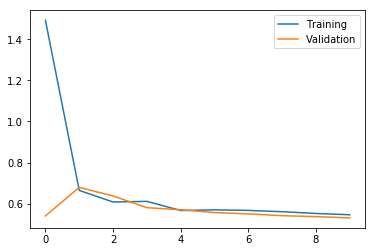

In [7]:
rec_model = RecurrentModel()
rec_model.train()


<a id=explodevanish></a>
### The exploding/vanishing gradient problem

The main problem with RNNs is their extremely high number of operations. The time dimension gives depth to their computational graph by stacking virtual copies one upon another, replicating a feedforward graph over and over while joining each copy to the preceding one.

Training such models require a lot of transformations of error signals.
We will focus on the two most used building blocks of ANNs: linear transformations and sigmoid activations.

We verified that backpropagating through a linear transformation $xW = s$ maps the incoming error signal $\delta s$ into

$$\delta x = \delta s W^T$$

This operation is itself a linear transformation, which using the polar decomposition can be decomposed into rigid rotations and homotecies: if these homotecies are such that the maximum dilation

$$\|W^T\| = \sup_{\|s\|=1} {\|s W^T\|}$$

is large, the outgoing error signal $\delta x$ might have a greater norm that the incoming one.
Imagine now to replace $s$ with $s_{t}$ and $x$ with $s_{t-1}$.
RNNs do these kind of manipulations over and over when moving *horizontally* through time (i.e. not changing the feature space of the internal memory, but only going back through time through preceding representations in that space): if $\|W^T\|$ is large, eventually there will be some $\delta s_{t-k}$ which norm has exploded!

This is known as the **exploding gradient** problem.
This problem can be effectively tackled by the so-called *gradient clipping*.
Once BPTT has terminated computing the updated $\delta \theta_{t}$, these vectors are rescaled to have a maximum norm

$$\delta \theta_{t}' =
\begin{cases} \delta \theta_{t} \frac{K}{\|\delta \theta_{t}\|}, &\text{if } \|\delta \theta_{t}\| > K \\
              \delta \theta_{t}, &\text{if } \|\delta \theta_{t}\| \leq K
\end{cases}$$

which is, they are cut if they are longer than a fixed *clipping threshold* $K$.

The second problem arises for sigmoid and hyperbolic tangent transformations.
When we implemented the `backward` methods of such operations, we pointed out that the maximum value of the sigmoid derivative is $\frac{1}{4}$, while that of the hyperbolic tangent is $\frac{1}{2}$.
This implies that filtering an incoming error signal $\delta h$ back through a sigmoid layer yields an outgoing error signal with norm

$$\|\delta s\| \leq \frac{1}{4}\|\delta h\|$$

As for linear transformations, this operations in a RNN are traversed bacward many times, and can quickly drive error signals to zero: this problem is known as **vanishing gradient**.
A solution analogous to the gradient clipping (we could call it *gradient blowing*) is not feasible since this must be performed *at the end* of BPTT, but concrete numerical implementations on computers introduce numerical approximations of small numbers to zero.
Thus, before inflating the gradient, if would have been turned to zero; and inflating zero yields zero.

To overcome the vanishing gradient problem, in 1997 Sepp Hochreiter and Jurgen Schmidhuber introduced a system of **gates** that instruct a RNN cell called a [Long Short-Term Memory](http://www.bioinf.jku.at/publications/older/2604.pdf) (LSTM) on which information about the past to forget, which information about the present to retain, and which combined information to unleash towards higher level abstractions.

In 2014, a cell called [Gated Recurrent Unit](https://arxiv.org/pdf/1406.1078.pdf) (GRU) was proposed, which has shown similar performance to that of LSTMs, but with a simpler architecture.

LSTMs and GRUs are now the basic building blocks of Recurrent Neural Networks.


### References

**RNNs**: this [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy illustrates many applications of RNNs; Denny Britz's [blog post](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) guides you through another implementation of RNNs and LSTMs from scratch.

**LSTMs**: I strongly suggest to read Christopher Olah's [blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) about Long Short-Term Memories.
